# WIRED IMAGES
### AI IMAGE CAPTIONING BOT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [2]:
def readTextFiles(path):
    with open(path) as f:
        captions=f.read()
    return captions
    
        

In [3]:
captions = readTextFiles('Dataset/Flickr8k_text/Flickr8k.token.txt')

In [4]:
print(captions)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
print(len(captions.split('\n')))

40461


In [6]:
captions=captions.split('\n')

In [7]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [8]:
captions[-1]

''

In [9]:
captions[-2]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [10]:
captions=captions[:-1]

In [11]:
print(len(captions))

40460


In [12]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [13]:
captions[1]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

In [14]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

### Dictionary to Map each Image with the list of captions it has

In [15]:
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [16]:
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [17]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [18]:
first,second=captions[0].split('\t')
print(first.split('.')[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [19]:
descriptions={}
for x in captions:
    first,second=x.split('\t')
    img_name = first.split('.')[0]
    #Check if imageid already present or not
    if(descriptions.get(img_name)) is None :
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [20]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

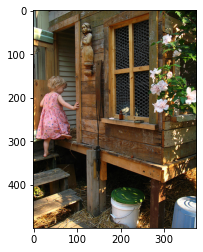

In [21]:
IMG_PATH = 'Dataset/Flicker8k_Dataset/'
import cv2
import matplotlib.pyplot as plt

img=cv2.imread(IMG_PATH+'1000268201_693b08cb0e.jpg')
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### DATA CLEANING

In [22]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence
    

In [23]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [24]:
# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [25]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [26]:
# Write the data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary 

In [27]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [28]:
print(type(descriptions))

<class 'dict'>


In [29]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [30]:
# Total No of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [31]:
# Filter Words from the Vocab according to certain threshold frequncy

In [32]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [33]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [34]:
print(len(total_words)) 

1845


### Prepare Train/Test Data

In [35]:
train_file_data = readTextFiles("Dataset/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFiles("Dataset/Flickr8k_text/Flickr_8k.testImages.txt")


In [36]:
print(train_file_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [37]:
train = [row for row in train_file_data.split("\n")[:-1]]
test = [row for row in test_file_data.split("\n")[:-1]]

In [38]:
train[:5]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg']

In [39]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [40]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

### Prepare Description for the Training Data

### Tweak - Add < s > and < e > token to our training data

In [41]:

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [42]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- Images --> Features
- Text ---> Features 

### Step - 1 Image Feature Extraction

In [43]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [44]:
model.layers[-2]

In [45]:
model.layers[-2].output

<tf.Tensor 'avg_pool/Mean:0' shape=(None, 2048) dtype=float32>

In [46]:
model_new = Model(model.input,model.layers[-2].output)

In [47]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


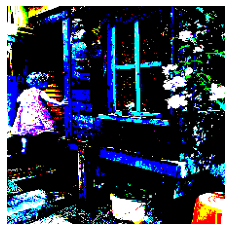

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [48]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

#Done by resnet do not worry about this
print(img)

In [49]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [50]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535921, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [51]:
""""
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

"""


'"\nstart = time()\nencoding_train = {}\n#image_id -->feature_vector extracted from Resnet Image\n\nfor ix,img_id in enumerate(train):\n    img_path = IMG_PATH+"/"+img_id+".jpg"\n    encoding_train[img_id] = encode_image(img_path)\n    \n    if ix%100==0:\n        print("Encoding in Progress Time step %d "%ix)\n        \nend_t = time()\nprint("Total Time Taken :",end_t-start)\n\n'

In [52]:
"""
!mkdir saved
"""


'\n!mkdir saved\n'

In [53]:
"""
# Store everything to the disk 
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
"""

'\n# Store everything to the disk \nwith open("saved/encoded_train_features.pkl","wb") as f:\n    pickle.dump(encoding_train,f)\n'

In [54]:
"""
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)
"""

'\nstart = time()\nencoding_test = {}\n#image_id -->feature_vector extracted from Resnet Image\n\nfor ix,img_id in enumerate(test):\n    img_path = IMG_PATH+"/"+img_id+".jpg"\n    encoding_test[img_id] = encode_image(img_path)\n    \n    if ix%100==0:\n        print("Test Encoding in Progress Time step %d "%ix)\n        \nend_t = time()\nprint("Total Time Taken(test) :",end_t-start)\n'

In [55]:
"""
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)
"""

'\nwith open("saved/encoded_test_features.pkl","wb") as f:\n    pickle.dump(encoding_test,f)\n'

In [56]:
with open('saved/encoded_train_features.pkl','rb') as f1:
    encoding_train = pickle.load(f1)
with open('saved/encoded_test_features.pkl','rb') as f2:
    encoding_test = pickle.load(f2)

### Data pre-processing for Captions

In [57]:
len(total_words)

1845

In [58]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [59]:
word_to_idx["dog"]

6

In [60]:
idx_to_word[6]

'dog'

In [61]:
print(len(idx_to_word))

1845


In [62]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [63]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [64]:
with open('./storage/word_to_idx.pkl','wb') as w2i:
    pickle.dump(word_to_idx,w2i)
with open('./storage/idx_to_word.pkl','wb') as i2w:
    pickle.dump(idx_to_word,i2w)

### Data Loader (Generator)

In [65]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

## WORD EMBEDDINGS

In [66]:
f = open("./saved/glove.6B.50d.txt",encoding='utf8')

In [67]:
embedding_index = {}

for line in f:
    values = line.split()
    print(values)
    break

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581']


In [68]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [69]:
f.close()

In [70]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [71]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        

In [72]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [73]:
embedding_matrix[200]

array([ 0.87813 ,  0.64696 ,  0.31447 ,  0.1683  ,  0.1936  ,  0.085991,
       -1.1177  , -1.0544  ,  0.07278 , -0.58128 , -0.83187 , -0.37427 ,
        1.064   , -1.0586  ,  0.084875,  0.29492 ,  0.35512 ,  0.23121 ,
        0.18424 , -1.7912  , -1.1568  , -0.74142 ,  0.40801 , -0.64031 ,
        0.86476 ,  0.53864 ,  0.24997 ,  1.0902  ,  0.98498 , -0.71896 ,
        2.834   , -0.67698 ,  0.014172, -0.068273, -0.15182 ,  0.61362 ,
       -0.56045 , -0.37151 ,  0.39271 , -0.044244, -1.0053  , -0.87896 ,
        0.056767,  0.1912  ,  1.5539  ,  0.43487 , -0.065982, -1.8907  ,
        0.065657, -1.4524  ])

In [74]:
embedding_matrix[1847] #Startseq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [75]:
embedding_matrix[1846] #Endseq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [76]:
embedding_matrix[1845]

array([-0.34126 , -0.06117 ,  0.93339 , -0.48938 , -0.16882 ,  0.76947 ,
        0.11972 , -0.11674 , -0.54492 , -0.44433 , -0.44316 , -0.10517 ,
       -0.086709,  0.13392 , -1.0489  , -0.10756 ,  0.4921  ,  0.62526 ,
       -1.5142  , -0.88477 ,  0.28845 ,  0.26258 ,  0.10793 , -0.92586 ,
       -0.043537, -0.67035 ,  0.22245 ,  0.28499 ,  0.32135 , -0.22713 ,
        1.0602  , -0.89463 , -0.14558 , -0.041262,  0.19645 ,  0.65909 ,
        0.85064 , -0.34087 ,  0.19177 ,  0.49908 ,  1.0036  ,  0.70362 ,
       -0.41316 , -0.47519 ,  0.94353 ,  0.14839 , -0.42612 , -0.5682  ,
       -0.6244  ,  0.30874 ])

# Model Architecture

In [77]:
#Input Feature Extractor Model
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [78]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [79]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

In [80]:
# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [81]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [82]:
#Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [83]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [84]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

# Training of Model

In [85]:
epochs = 20
batch_size = 3
#steps = len(train_descriptions)//number_pics_per_batch

In [86]:
"""
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')
"""

"\ndef train():\n    \n    for i in range(epochs):\n        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)\n        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)\n        model.save('./model_weights/model_'+str(i)+'.h5')\n"

In [87]:
model = load_model('./model_weights/model_9.h5')

# Predictions

In [88]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

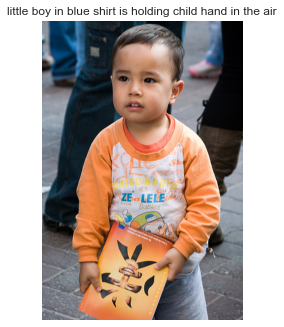

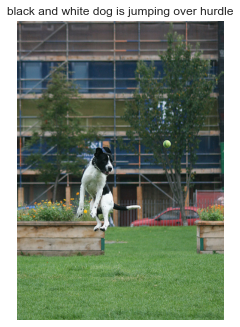

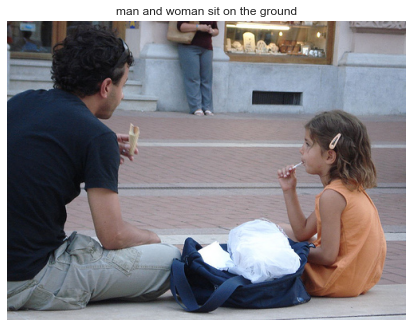

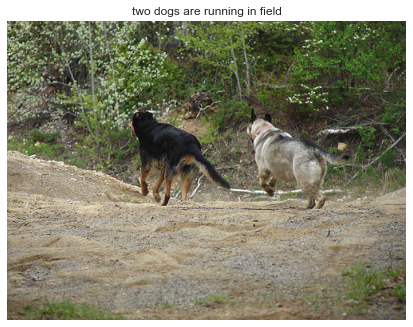

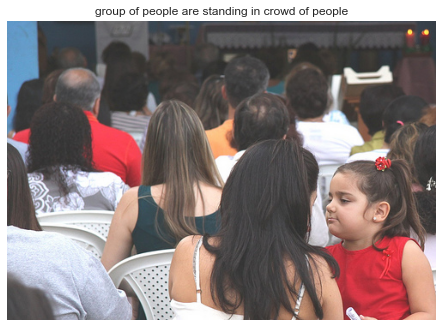

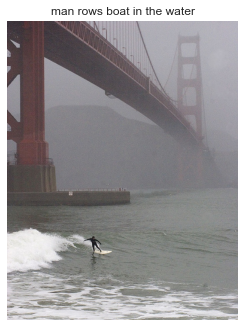

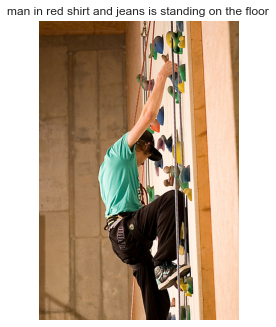

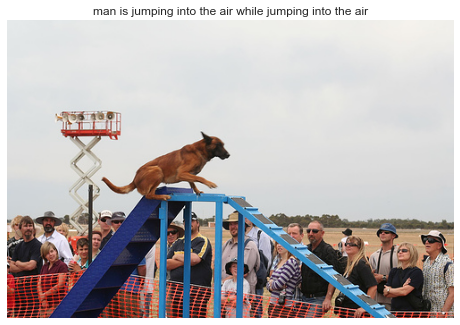

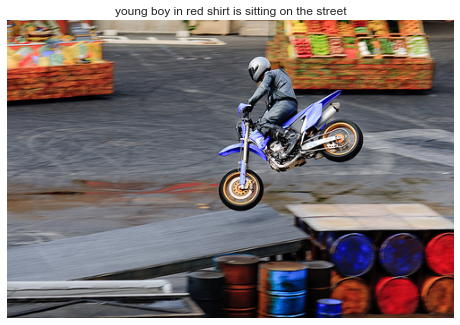

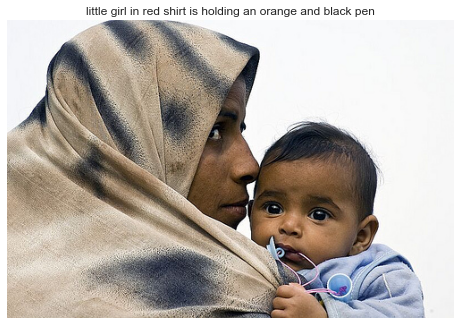

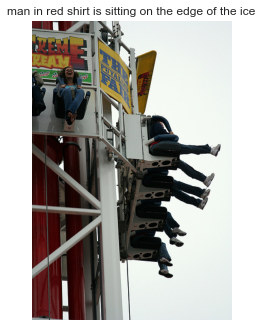

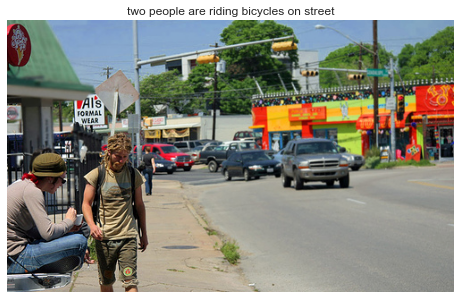

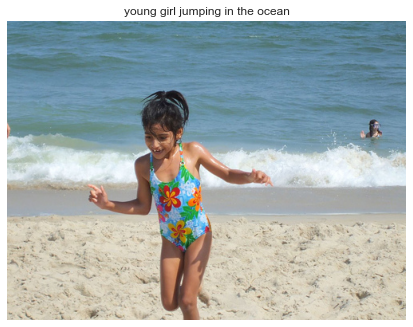

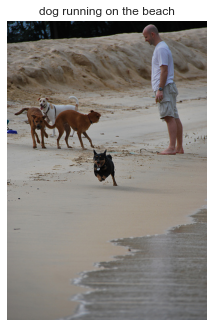

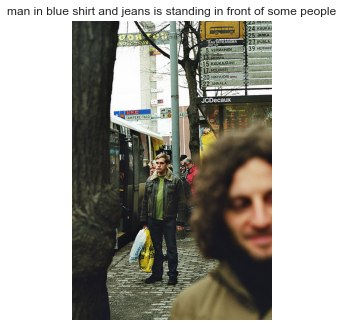

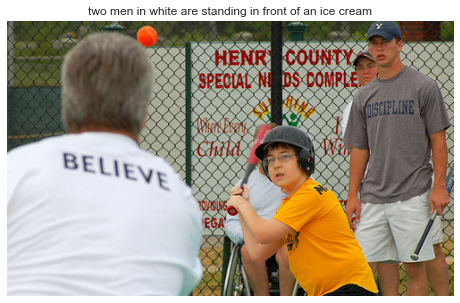

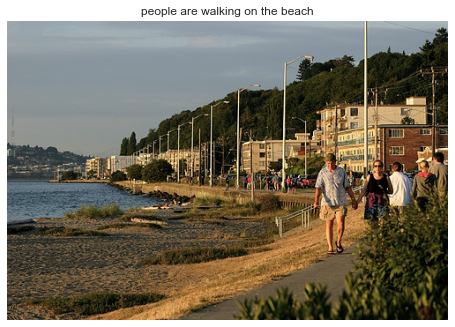

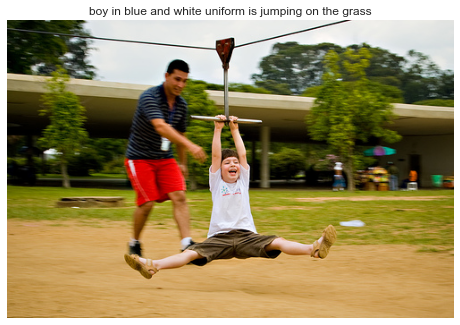

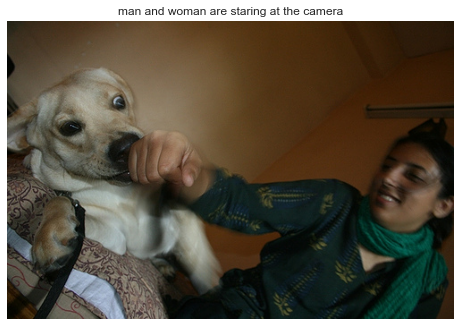

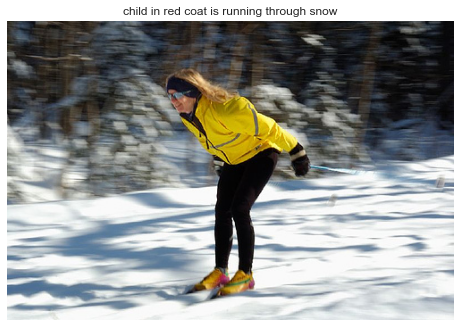

In [89]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15,35):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Dataset/Flicker8k_Dataset/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()